In [1]:
import os
import torch
import torch.nn as nn
import lightning.pytorch as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import Config, configurations
from src.data import get_data, get_collator
from src.tiny_sleep_net import TinySleepNet
from src.model import SleepStagingModel

In [2]:
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    pl.seed_everything(seed)

seed_everything(42)

Global seed set to 42


# Baseline

In [9]:
checkpoint_path = os.path.join("experiments_logs", "baseline_gpu", "version_2", "checkpoints", "epoch=199-step=1800.ckpt")

In [10]:
cfg: Config = configurations["baseline_gpu"]
*_, test_loader = get_data(
    root=cfg.data_dir,
    batch_size=cfg.batch_size,
    train_percentage=0.8,
    val_percentage=0.1,
    test_percentage=0.1,
    collate_fn=get_collator(low_resources=cfg.low_resources)
)

In [11]:

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1., 1.5, 1., 1., 1.]))
model = SleepStagingModel.load_from_checkpoint(
    checkpoint_path, 
    map_location=torch.device("cpu"),
    model=TinySleepNet(cfg),
    cost_function=criterion,
    config=cfg,
    evaluate=True
)
model.freeze()
trainer = pl.Trainer()

out = trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Accuracy/Test       │     84.01256561279297     │
│         Loss/Test         │    0.4910277724266052     │
└───────────────────────────┴───────────────────────────┘

In [12]:
pd.DataFrame(model.results["report"]).T.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,2))).to_latex("results.tex")

In [13]:
model.results["matrix"]

array([[109,   1,   7,   0,   8],
       [  1,   8,  11,   0,  25],
       [  0,   2, 342,  32,  24],
       [  0,   0,   1, 130,   0],
       [  0,   0,  15,   0, 184]], dtype=int64)

In [14]:
model.results["matrix_norm"]

array([[0.99090909, 0.09090909, 0.01861702, 0.        , 0.03319502],
       [0.00909091, 0.72727273, 0.02925532, 0.        , 0.10373444],
       [0.        , 0.18181818, 0.90957447, 0.19753086, 0.09958506],
       [0.        , 0.        , 0.00265957, 0.80246914, 0.        ],
       [0.        , 0.        , 0.03989362, 0.        , 0.76348548]])

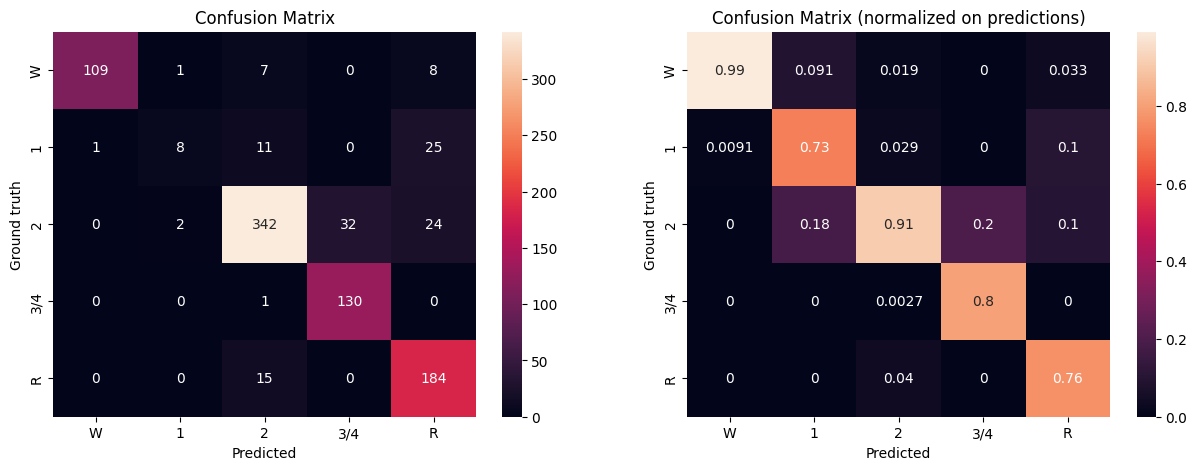

In [16]:
from data.prepare_sleepedf import label2ann
labels = [label[12:] for label in label2ann.values()]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(model.results["matrix"], annot=True, fmt="d",  ax=ax1, xticklabels=labels, yticklabels=labels)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Ground truth")
sns.heatmap(model.results["matrix_norm"], annot=True, ax=ax2, xticklabels=labels, yticklabels=labels)
ax2.set_title("Confusion Matrix (normalized on predictions)")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Ground truth")
plt.show()

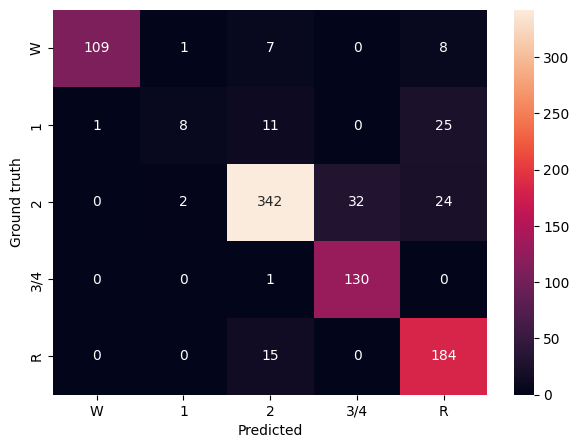

In [21]:
from data.prepare_sleepedf import label2ann
labels = [label[12:] for label in label2ann.values()]
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(model.results["matrix"], annot=True, fmt="d",  ax=ax1, xticklabels=labels, yticklabels=labels)
# ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Ground truth")
plt.show()

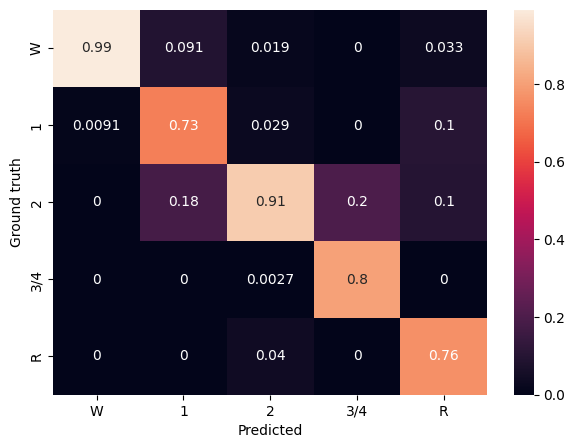

In [22]:
from data.prepare_sleepedf import label2ann
labels = [label[12:] for label in label2ann.values()]
fig, ax2 = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(model.results["matrix_norm"], annot=True, ax=ax2, xticklabels=labels, yticklabels=labels)
# ax2.set_title("Confusion Matrix (normalized on predictions)")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Ground truth")
plt.show()

# HMC

In [3]:
conf = "hmc_gpu_3ch_e30"
checkpoint_path = os.path.join("experiments_logs_hpc", conf, "version_2", "checkpoints", "epoch=199-step=1800.ckpt")
cfg: Config = configurations[conf]
*_, test_loader = get_data(
    root=cfg.data_dir,
    dataset=cfg.dataset,
    epoch_duration=cfg.epoch_duration,
    selected_channels=cfg.in_channels,
    batch_size=cfg.batch_size,
    test_batch_size=cfg.test_batch_size,
    train_percentage=0.9,
    val_percentage=0.0,
    test_percentage=0.1,
    train_collate_fn=get_collator(
        sampling_rate=cfg.sampling_rate,
        in_channels=cfg.n_in_channels,
        epoch_duration=cfg.epoch_duration,
        low_resources=cfg.low_resources),
    test_collate_fn=get_collator(
        sampling_rate=cfg.sampling_rate,
        in_channels=cfg.n_in_channels,
        epoch_duration=cfg.epoch_duration,
        low_resources=cfg.low_resources,
        is_test_set=True)
)

In [4]:

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1., 1.5, 1., 1., 1.]))
model = SleepStagingModel.load_from_checkpoint(
    checkpoint_path, 
    map_location=torch.device("cpu"),
    model=TinySleepNet(cfg),
    cost_function=criterion,
    config=cfg,
    evaluate=True
)
model.freeze()
trainer = pl.Trainer()

trainer.test(model, test_loader)

c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\lightning\pytorch\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.3, which is newer than your current Lightning version: v2.0.2
  rank_zero_warn(


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\febbr\Projects\5AUA0-Project4\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Accuracy/Test       │     78.16526794433594     │
│         Loss/Test         │    0.6004980802536011     │
└───────────────────────────┴───────────────────────────┘

[{'Loss/Test': 0.6004980802536011, 'Accuracy/Test': 78.16526794433594}]

In [5]:
results = model.compute_metrics()

In [8]:
pd.DataFrame(results["report"]).T.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,2)))

,precision,recall,f1-score,support
Sleep stage W,0.96,0.79,0.87,2982
Sleep stage 1,0.53,0.57,0.54,1943
Sleep stage 2,0.86,0.71,0.78,4894
Sleep stage 3/4,0.69,0.97,0.81,2371
Sleep stage R,0.81,0.91,0.86,2090
accuracy,0.78,0.78,0.78,0.78
macro avg,0.77,0.79,0.77,14280
weighted avg,0.8,0.78,0.78,14280


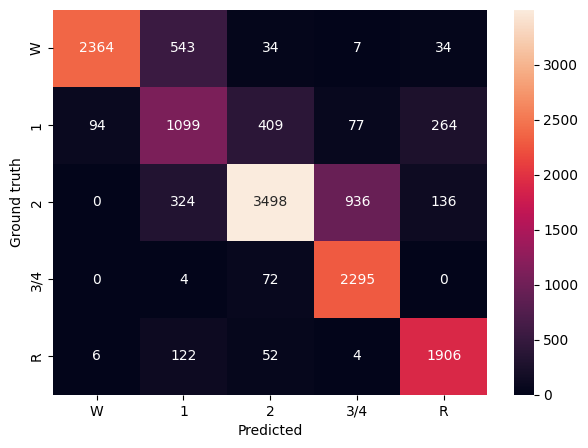

In [10]:
from data.prepare_sleepedf import label2ann
labels = [label[12:] for label in label2ann.values()]
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(results["matrix"], annot=True, fmt="d",  ax=ax1, xticklabels=labels, yticklabels=labels)
# ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Ground truth")
plt.show()